In [63]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import tqdm
import pandas as pd
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det

import matplotlib.pyplot as plt

1.21.0
1.7.3


In [64]:
def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return -K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    #print("partial mu, partial K: ", partial_mu(t, theta, 'K'))
    #print("partial mu, partial P: ", partial_mu(t, theta, 'P'))
    #print("partial mu, partial T0: ", partial_mu(t, theta, 'T0'))
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    fim = np.zeros((len(theta),len(theta)))
    for i in range(len(theta)):
        for j in range(len(theta)):
            #param_i = theta[i]
            #param_j = theta[j]
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed
            #print(factor1)
            ###factor2 = 1/sigma**2 # inverse of covariance matrix (or just the RV variance if held constant)
            ###factor2[factor2 == np.inf] = 0 # turn infs into zeros (shouldn't it be nans?)
            #print(factor2)
            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter
            #print(factor3)
            #print("shapes: ", factor1.shape, factor2.shape, factor3.shape)
            #print(np.dot(np.dot(factor1, factor2), factor3))
            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

In [107]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days

test_theta = [test_K, test_P, test_T0]

def make_t(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(2300, end, n_obs)
    
    return t

def strategy(start, n_obs, cadence, theta, sigma_val):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)
    
    sigma = np.diag(np.ones(len(t))*sigma_val) # cm/s
    
    fim = calculate_fim(t, sigma, theta)
    #print("FIM: ", fim)
    #print("det: ", det(fim))
    inv_fim = inv(fim)
    #print("inv: ", inv_fim)
    sigma_k = np.sqrt(inv_fim)[0][0]
    #print("sigma_K, using inv: ", sigma_k)
    #sigma_ks.append(sigma_k)
    sigma_k_stable = np.sqrt(1/fim[0][0])
    #print("sigma_K, not using inv: ", sigma_k_stable)
    
    return sigma_k, sigma_k_stable

strategy(start=2352, n_obs=100, cadence=1, theta=test_theta, sigma_val=30) # default to 2300

/tmp/ipykernel_3016473/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/tmp/ipykernel_3016473/2987792116.py:64: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


(4.2492174893277666, 4.249001943889739)

#### Let's generate lots of different strategies using a variety of combinations of n_obs and cadences. 

In [109]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)
sigma_ks = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))

#with tqdm.tqdm(total=100) as pbar:
for enum_i, i in enumerate(n_observations):
    for enum_j, j in enumerate(cadences):
        #print(i, j)
        sigma_k, sigma_k_stable = strategy(start=2352, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)
        #print(sigma_k, sigma_k_stable)

        sigma_ks[enum_i][enum_j] = sigma_k
        sigma_ks_stable[enum_i][enum_j] = sigma_k_stable


/tmp/ipykernel_3016473/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/tmp/ipykernel_3016473/2987792116.py:64: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


In [110]:
sigma_ks_stable.shape

(100, 100)

In [111]:
n_observations

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102])

In [112]:
cadences

array([0.3       , 0.36616162, 0.43232323, 0.49848485, 0.56464646,
       0.63080808, 0.6969697 , 0.76313131, 0.82929293, 0.89545455,
       0.96161616, 1.02777778, 1.09393939, 1.16010101, 1.22626263,
       1.29242424, 1.35858586, 1.42474747, 1.49090909, 1.55707071,
       1.62323232, 1.68939394, 1.75555556, 1.82171717, 1.88787879,
       1.9540404 , 2.02020202, 2.08636364, 2.15252525, 2.21868687,
       2.28484848, 2.3510101 , 2.41717172, 2.48333333, 2.54949495,
       2.61565657, 2.68181818, 2.7479798 , 2.81414141, 2.88030303,
       2.94646465, 3.01262626, 3.07878788, 3.14494949, 3.21111111,
       3.27727273, 3.34343434, 3.40959596, 3.47575758, 3.54191919,
       3.60808081, 3.67424242, 3.74040404, 3.80656566, 3.87272727,
       3.93888889, 4.00505051, 4.07121212, 4.13737374, 4.20353535,
       4.26969697, 4.33585859, 4.4020202 , 4.46818182, 4.53434343,
       4.60050505, 4.66666667, 4.73282828, 4.7989899 , 4.86515152,
       4.93131313, 4.99747475, 5.06363636, 5.12979798, 5.19595

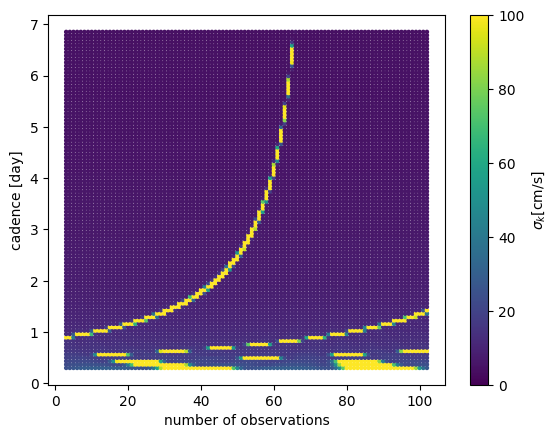

In [115]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks, s=5, vmin=0, vmax=100)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.savefig("n_obs-cadence-sigma_k.pdf", format="pdf")
plt.show()

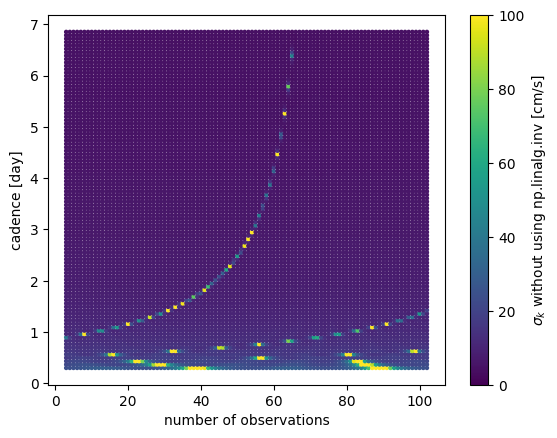

In [116]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable, s=5, vmin=0, vmax=100)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$ without using np.linalg.inv [cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.savefig("n_obs-cadence-sigma_k-stable.pdf", format="pdf")
plt.show()